In [1]:
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

In [3]:
df = pd.read_csv('online_retail.csv', encoding='latin-1')

print("Data Shape:", df.shape)
df.head()


Data Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


Data Pre-processing

In [4]:
print(df.info())

print(df.describe())

print("Unique Invoices:", df['InvoiceNo'].nunique())
print("Unique StockCodes:", df['StockCode'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000

In [5]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]
df = df.dropna(subset=['CustomerID'])

print("Data Shape after cleaning:", df.shape)

Data Shape after cleaning: (397924, 8)


Data Encoding

In [6]:
transactions = df.groupby('InvoiceNo')['StockCode'].apply(list)
print("Example of a single transaction list:\n", transactions.iloc[0])

Example of a single transaction list:
 ['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730']


In [7]:
transactions_list = transactions.tolist()

te = TransactionEncoder()

te_ary = te.fit(transactions_list).transform(transactions_list)

df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("Shape of the encoded DataFrame:", df_encoded.shape)
print(df_encoded.iloc[0:5, 0:5])

Shape of the encoded DataFrame: (18536, 3665)
   10002  10080  10120  10123C  10124A
0  False  False  False   False   False
1  False  False  False   False   False
2  False  False  False   False   False
3  False  False  False   False   False
4  False  False  False   False   False


Apriori Algorithm

In [8]:
freq_itemsets_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)

print("Apriori - Frequent Itemsets (sample):")
freq_itemsets_apriori.head(10)


Apriori - Frequent Itemsets (sample):


,support,itemsets
0,0.017479,(15036)
1,0.015699,(15056BL)
2,0.020393,(15056N)
3,0.013379,(16161P)
4,0.011114,(17003)
5,0.012031,(20675)
6,0.016077,(20676)
7,0.011869,(20677)
8,0.014566,(20679)
9,0.031075,(20685)


In [9]:
#Generating association rules
rules = association_rules(freq_itemsets_apriori, metric="confidence", min_threshold=0.5)
print("Association Rules (sample):")
rules.head()


Association Rules (sample):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(20712),(85099B),0.026543,0.086319,0.014135,0.532520,6.169248,1.0,0.011844,1.954484,0.860753,0.143169,0.488356,0.348135
1,(20719),(20724),0.028647,0.039868,0.015591,0.544256,13.651328,1.0,0.014449,2.106735,0.954078,0.294597,0.525332,0.467663
2,(20723),(20724),0.026543,0.039868,0.015969,0.601626,15.090311,1.0,0.014911,2.410126,0.959192,0.316578,0.585084,0.501084
3,(22355),(20724),0.031560,0.039868,0.016077,0.509402,12.777091,1.0,0.014819,1.957063,0.951773,0.290448,0.489030,0.456325
4,(22356),(20724),0.026273,0.039868,0.017372,0.661191,16.584351,1.0,0.016324,2.833843,0.965057,0.356195,0.647122,0.548457


In [9]:
#filtering for strong rules
filtered_rules = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.7)]
print("\nFiltered Rules (lift > 1.2 & confidence > 0.7):")
filtered_rules.head()


Filtered Rules (lift > 1.2 & confidence > 0.7):
   antecedents consequents  antecedent support  consequent support   support  \
11     (21094)     (21080)            0.017533            0.039491  0.012354   
12     (21086)     (21094)            0.015375            0.017533  0.012732   
13     (21094)     (21086)            0.017533            0.015375  0.012732   
14     (21136)     (84879)            0.018990            0.074180  0.013757   
31     (21933)     (21932)            0.015268            0.017210  0.010736   

    confidence       lift  representativity  leverage  conviction  \
11    0.704615  17.842556               1.0  0.011662    3.251724   
12    0.828070  47.228027               1.0  0.012462    5.714346   
13    0.726154  47.228027               1.0  0.012462    3.595539   
14    0.724432   9.765868               1.0  0.012348    3.359677   
31    0.703180  40.859399               1.0  0.010473    3.311067   

    zhangs_metric   jaccard  certainty  kulczynski  
11

Total count of Rules

In [10]:
print("\nNumber of rules found:", len(rules))


Number of rules found: 323


Visualtization

In [11]:
desc_map = (
    df[['StockCode', 'Description']]
    .drop_duplicates()
    .dropna(subset=['Description'])
)

code_to_desc = dict(zip(desc_map['StockCode'], desc_map['Description']))

def map_codes_to_descriptions(itemset, mapping):
    return [mapping[code] for code in itemset if code in mapping]

rules['antecedents_desc'] = rules['antecedents'].apply(lambda x: map_codes_to_descriptions(x, code_to_desc))
rules['consequents_desc'] = rules['consequents'].apply(lambda x: map_codes_to_descriptions(x, code_to_desc))

print(rules[['antecedents', 'antecedents_desc', 'consequents', 'consequents_desc']].head())


  antecedents               antecedents_desc consequents  \
0     (20712)   [JUMBO BAG WOODLAND ANIMALS]    (85099B)   
1     (20719)       [WOODLAND CHARLOTTE BAG]     (20724)   
2     (20723)     [STRAWBERRY CHARLOTTE BAG]     (20724)   
3     (22355)    [CHARLOTTE BAG SUKI DESIGN]     (20724)   
4     (22356)  [CHARLOTTE BAG PINK POLKADOT]     (20724)   

                consequents_desc  
0      [JUMBO BAG RED RETROSPOT]  
1  [RED RETROSPOT CHARLOTTE BAG]  
2  [RED RETROSPOT CHARLOTTE BAG]  
3  [RED RETROSPOT CHARLOTTE BAG]  
4  [RED RETROSPOT CHARLOTTE BAG]  


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [14]:
single_item_rules = rules[
    (rules['antecedents'].apply(lambda x: len(x)) == 1) &
    (rules['consequents'].apply(lambda x: len(x)) == 1)
]

G = nx.DiGraph()

for idx, row in single_item_rules.iterrows():
    ante = row['antecedents_desc'][0]
    cons = row['consequents_desc'][0]
    conf = row['confidence']
    lift = row['lift']
    
    G.add_node(ante, label=ante)
    G.add_node(cons, label=cons)
    G.add_edge(ante, cons, weight=conf, lift=lift)

Association Network for all the items.

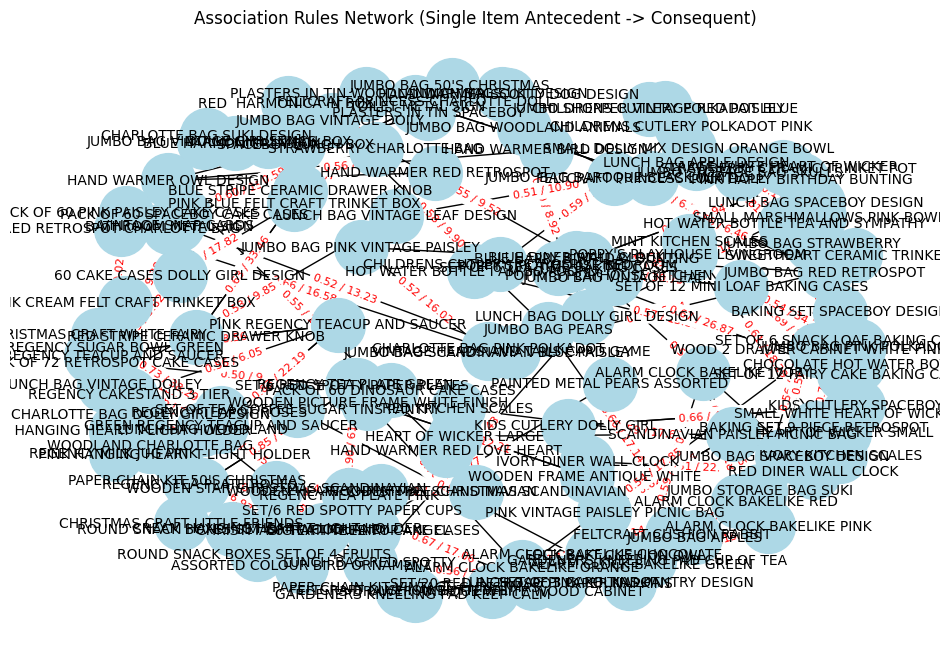

In [15]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f} / {d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Association Rules Network (Single Item Antecedent -> Consequent)")
plt.axis("off")
plt.show()


In [16]:
top_10_rules_by_confidence = rules.sort_values(by='confidence', ascending=False).head(10)
top_10_rules_by_lift = rules.sort_values(by='lift', ascending=False).head(10)
top_10_rules_by_support = rules.sort_values(by='support', ascending=False).head(10)


In [17]:
print("Top 10 Rules by Confidence:")
print(top_10_rules_by_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 Rules by Confidence:
               antecedents consequents   support  confidence       lift
297         (22745, 22746)     (22748)  0.010035    0.907317  48.607021
316  (22698, 22423, 22699)     (22697)  0.012894    0.901887  24.193015
104                (23172)     (23171)  0.010898    0.901786  61.909259
286         (22698, 22699)     (22697)  0.021040    0.894495  23.994742
314  (22698, 22697, 22423)     (22699)  0.012894    0.881919  20.877710
102                (23172)     (23170)  0.010628    0.879464  49.700457
277         (22698, 22423)     (22697)  0.014620    0.877023  23.526037
296         (22746, 22748)     (22745)  0.010035    0.865116  50.746188
282         (22698, 22423)     (22699)  0.014297    0.857605  20.302132
90                 (22746)     (22748)  0.011599    0.853175  45.706487


In [18]:
top_10_rules_by_confidence['antecedents_desc'] = top_10_rules_by_confidence['antecedents'].apply(
    lambda x: [code_to_desc[i] for i in x if i in code_to_desc]
)
top_10_rules_by_confidence['consequents_desc'] = top_10_rules_by_confidence['consequents'].apply(
    lambda x: [code_to_desc[i] for i in x if i in code_to_desc]
)

print(top_10_rules_by_confidence[['antecedents_desc', 'consequents_desc', 'support', 'confidence', 'lift']])


                                      antecedents_desc  \
297  [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...   
316  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
104                           [REGENCY TEA PLATE PINK]   
286  [PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
314  [PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
102                           [REGENCY TEA PLATE PINK]   
277  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
296  [POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...   
282  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
90                     [POPPY'S PLAYHOUSE LIVINGROOM ]   

                       consequents_desc   support  confidence       lift  
297         [POPPY'S PLAYHOUSE KITCHEN]  0.010035    0.907317  48.607021  
316   [GREEN REGENCY TEACUP AND SAUCER]  0.012894    0.901887  24.193015  
104          [REGENCY TEA PLATE GREEN ]  0.010898    0.901786  61.909259  
286   [GREEN REGENCY TEACUP AND SAUCER]  0.021040    0.894495

Association plot by confidence

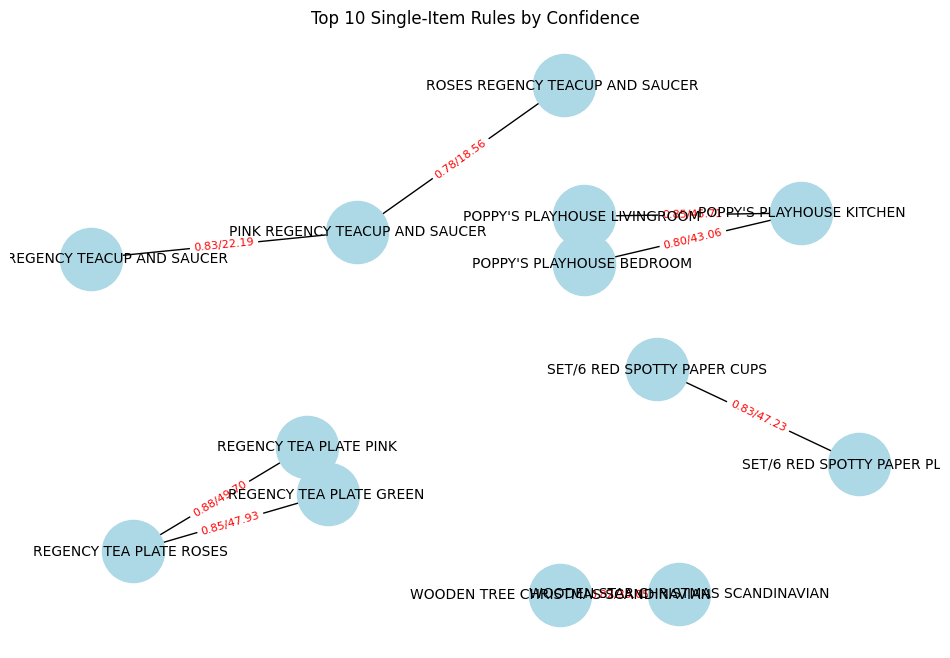

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

single_item_rules = rules[
    (rules['antecedents'].apply(lambda x: len(x)) == 1) &
    (rules['consequents'].apply(lambda x: len(x)) == 1)
]

top_10_single_item_rules = single_item_rules.sort_values(by='confidence', ascending=False).head(10)

G = nx.DiGraph()

for _, row in top_10_single_item_rules.iterrows():
    ante = row['antecedents_desc'][0]
    cons = row['consequents_desc'][0]
    conf = row['confidence']
    lift = row['lift']
    
    G.add_node(ante)
    G.add_node(cons)
    G.add_edge(ante, cons, weight=conf, lift=lift)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

edge_labels = {(u, v): f"{d['weight']:.2f}/{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Top 10 Single-Item Rules by Confidence")
plt.axis('off')
plt.show()


Association rule based on lift

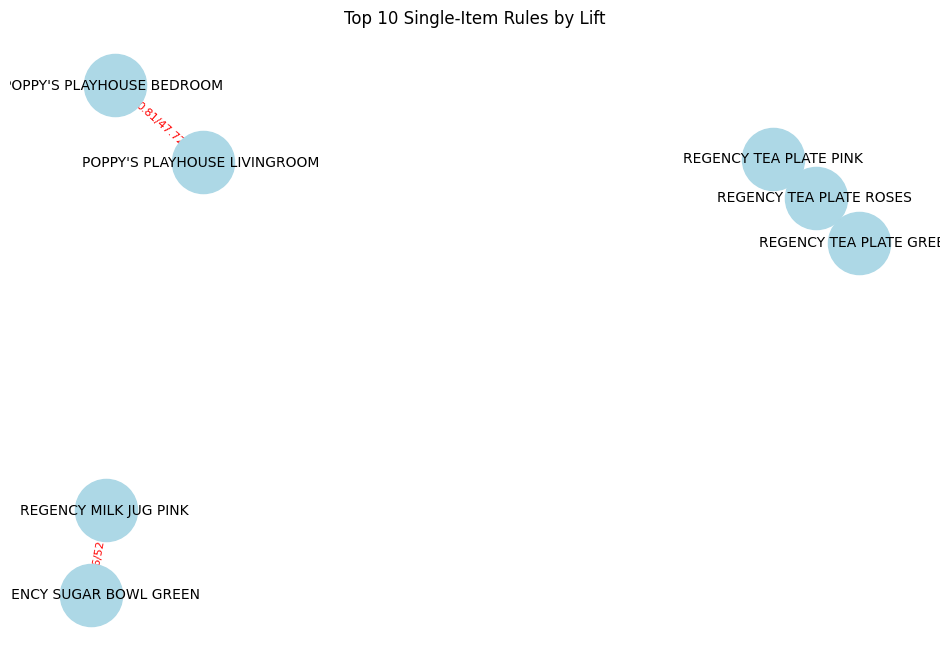

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

single_item_rules = rules[
    (rules['antecedents'].apply(lambda x: len(x)) == 1) &
    (rules['consequents'].apply(lambda x: len(x)) == 1)
]

top_10_single_item_rules = single_item_rules.sort_values(by='lift', ascending=False).head(10)

G = nx.DiGraph()

for _, row in top_10_single_item_rules.iterrows():
    ante = row['antecedents_desc'][0]
    cons = row['consequents_desc'][0]
    conf = row['confidence']
    lift = row['lift']
    
    G.add_node(ante)
    G.add_node(cons)
    G.add_edge(ante, cons, weight=conf, lift=lift)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

edge_labels = {(u, v): f"{d['weight']:.2f}/{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Top 10 Single-Item Rules by Lift")
plt.axis('off')
plt.show()


Association Rules based on support

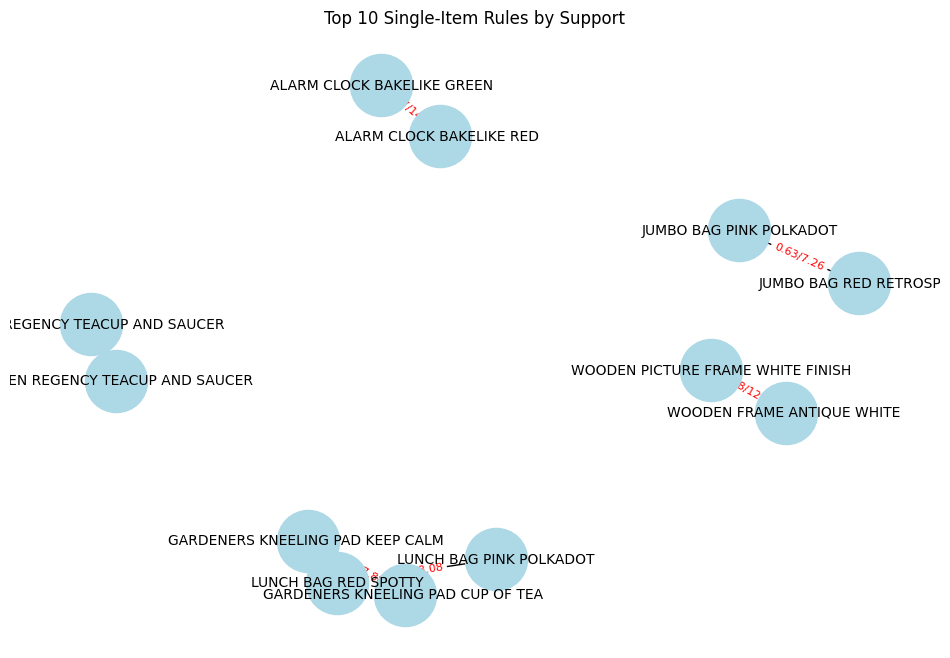

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

single_item_rules = rules[
    (rules['antecedents'].apply(lambda x: len(x)) == 1) &
    (rules['consequents'].apply(lambda x: len(x)) == 1)
]

top_10_single_item_rules = single_item_rules.sort_values(by='support', ascending=False).head(10)

G = nx.DiGraph()

for _, row in top_10_single_item_rules.iterrows():
    ante = row['antecedents_desc'][0]
    cons = row['consequents_desc'][0]
    conf = row['confidence']
    lift = row['lift']
    
    G.add_node(ante)
    G.add_node(cons)
    G.add_edge(ante, cons, weight=conf, lift=lift)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

edge_labels = {(u, v): f"{d['weight']:.2f}/{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Top 10 Single-Item Rules by Support")
plt.axis('off')
plt.show()


In [12]:
## FP-Growth
# considering min support = 0.01
freq_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

print("Number of frequent itemsets found:", len(freq_itemsets))
print(freq_itemsets.head())


Number of frequent itemsets found: 1031
    support  itemsets
0  0.106711  (85123A)
1  0.017318  (84029E)
2  0.017210  (84029G)
3  0.016023   (22752)
4  0.013487   (71053)


In [13]:
rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.5)
print("Number of rules:", len(rules))
rules.head()

Number of rules: 323


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(22632),(22865),0.019368,0.030859,0.010142,0.523677,16.970061,1.0,0.009545,2.034630,0.959659,0.253028,0.508510,0.426174
1,(22748),(22745),0.018666,0.017048,0.013703,0.734104,43.061242,1.0,0.013385,3.696755,0.995357,0.622549,0.729492,0.768951
2,(22745),(22748),0.017048,0.018666,0.013703,0.803797,43.061242,1.0,0.013385,5.001636,0.993718,0.622549,0.800065,0.768951
3,(22727),(22726),0.047313,0.042566,0.028593,0.604333,14.197612,1.0,0.026579,2.419798,0.975731,0.466549,0.586742,0.638035
4,(22726),(22727),0.042566,0.047313,0.028593,0.671736,14.197612,1.0,0.026579,2.902200,0.970892,0.466549,0.655434,0.638035


In [22]:
df_desc_map = df[['StockCode', 'Description']].drop_duplicates().dropna()
code_to_desc = dict(zip(df_desc_map['StockCode'], df_desc_map['Description']))

def map_itemset_to_desc(itemset, mapping):
    return [mapping[code] for code in itemset if code in mapping]

rules['antecedents_desc'] = rules['antecedents'].apply(lambda x: map_itemset_to_desc(x, code_to_desc))
rules['consequents_desc'] = rules['consequents'].apply(lambda x: map_itemset_to_desc(x, code_to_desc))

print(rules[['antecedents_desc', 'consequents_desc', 'support', 'confidence', 'lift']].head())


               antecedents_desc              consequents_desc   support  \
0   [HAND WARMER RED RETROSPOT]      [HAND WARMER OWL DESIGN]  0.010142   
1  [POPPY'S PLAYHOUSE BEDROOM ]   [POPPY'S PLAYHOUSE KITCHEN]  0.013703   
2   [POPPY'S PLAYHOUSE KITCHEN]  [POPPY'S PLAYHOUSE BEDROOM ]  0.013703   
3   [ALARM CLOCK BAKELIKE RED ]  [ALARM CLOCK BAKELIKE GREEN]  0.028593   
4  [ALARM CLOCK BAKELIKE GREEN]   [ALARM CLOCK BAKELIKE RED ]  0.028593   

   confidence       lift  
0    0.523677  16.970061  
1    0.803797  43.061242  
2    0.734104  43.061242  
3    0.604333  14.197612  
4    0.671736  14.197612  


In [23]:
top_10_by_conf = rules.sort_values(by='confidence', ascending=False).head(10)
top_10_by_lift = rules.sort_values(by='lift', ascending=False).head(10)


In [27]:
print(top_10_rules_by_confidence[['antecedents_desc', 'consequents_desc', 'support', 'confidence', 'lift']])

                                      antecedents_desc  \
297  [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...   
316  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
104                           [REGENCY TEA PLATE PINK]   
286  [PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
314  [PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
102                           [REGENCY TEA PLATE PINK]   
277  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
296  [POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...   
282  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
90                     [POPPY'S PLAYHOUSE LIVINGROOM ]   

                       consequents_desc   support  confidence       lift  
297         [POPPY'S PLAYHOUSE KITCHEN]  0.010035    0.907317  48.607021  
316   [GREEN REGENCY TEACUP AND SAUCER]  0.012894    0.901887  24.193015  
104          [REGENCY TEA PLATE GREEN ]  0.010898    0.901786  61.909259  
286   [GREEN REGENCY TEACUP AND SAUCER]  0.021040    0.894495

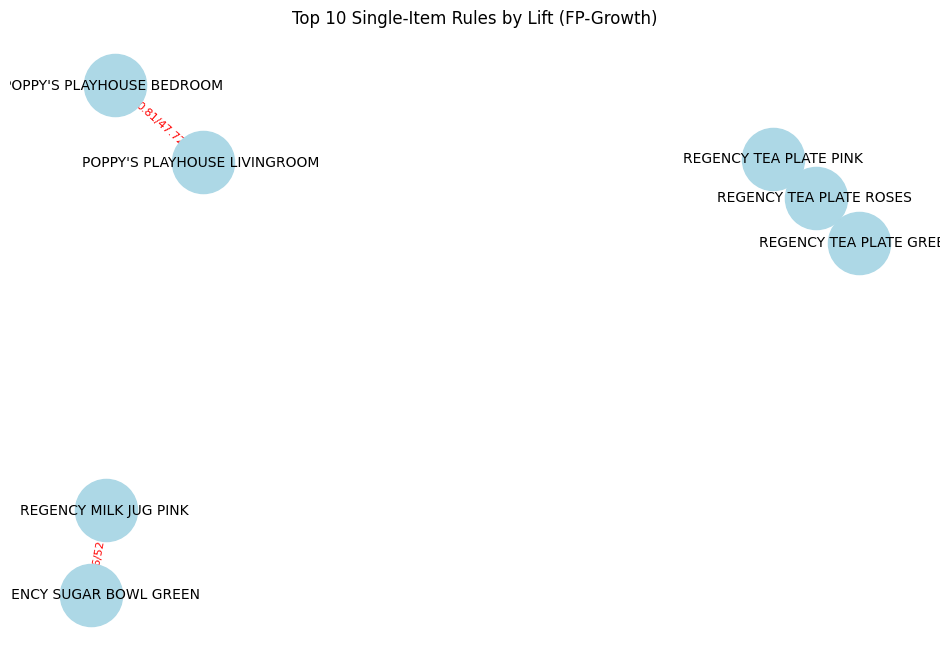

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

single_item_rules = rules[
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
]

top_10_single_item_rules = single_item_rules.sort_values(by='lift', ascending=False).head(10)

G = nx.DiGraph()

for idx, row in top_10_single_item_rules.iterrows():
    ante_desc = row['antecedents_desc'][0]
    cons_desc = row['consequents_desc'][0]
    
    conf = row['confidence']
    lift = row['lift']
    G.add_node(ante_desc)
    G.add_node(cons_desc)
    
    G.add_edge(ante_desc, cons_desc, weight=conf, lift=lift)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

edge_labels = {(u, v): f"{d['weight']:.2f}/{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Top 10 Single-Item Rules by Lift (FP-Growth)")
plt.axis('off')
plt.show()


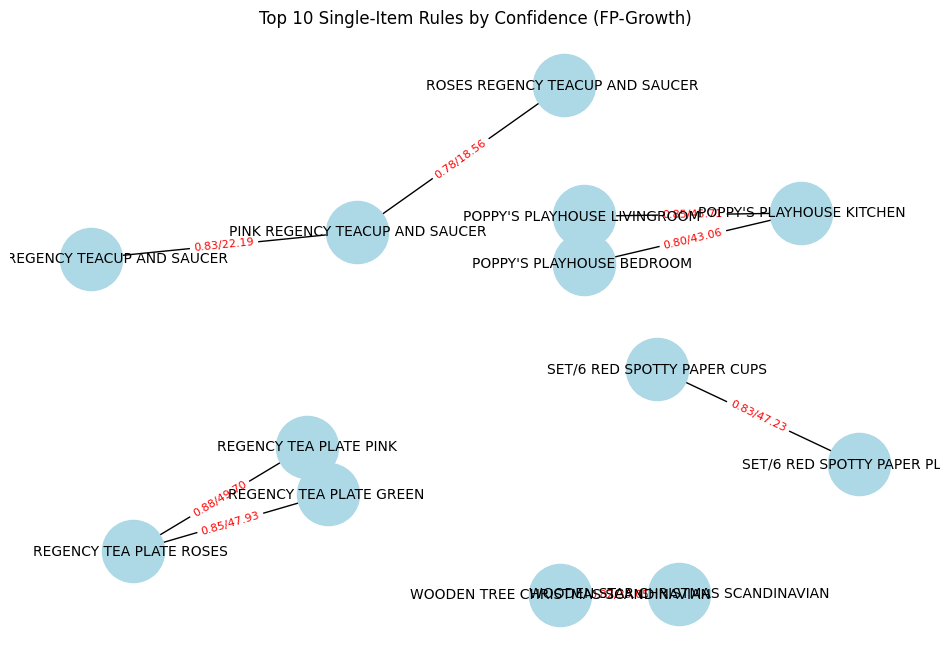

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

single_item_rules = rules[
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
]

top_10_single_item_rules = single_item_rules.sort_values(by='confidence', ascending=False).head(10)

G = nx.DiGraph()

for idx, row in top_10_single_item_rules.iterrows():
    ante_desc = row['antecedents_desc'][0]
    cons_desc = row['consequents_desc'][0]
    
    conf = row['confidence']
    lift = row['lift']
    
    G.add_node(ante_desc)
    G.add_node(cons_desc)
    
    G.add_edge(ante_desc, cons_desc, weight=conf, lift=lift)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

edge_labels = {(u, v): f"{d['weight']:.2f}/{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Top 10 Single-Item Rules by Confidence (FP-Growth)")
plt.axis('off')
plt.show()


**Frequently Purchased Items**
1. Frequently Purchased Itemsets
From the antecedent → consequent pairs and their support values, we can see several product pairs that appear together often enough to form strong rules:
<br>
HAND WARMER RED RETROSPOT ↔ HAND WARMER OWL DESIGN <br>
POPPY’S PLAYHOUSE BEDROOM ↔ POPPY’S PLAYHOUSE KITCHEN <br>
ALARM CLOCK BAKELIKE RED ↔ ALARM CLOCK BAKELIKE GREEN <br>
Although the individual supports (around 1–3%) may not be extremely high, these items frequently co-occur relative to how often they appear individually (hence very high lift).

**Insights of Each rule**

2.1 Hand Warmers:
Rule: (HAND WARMER RED RETROSPOT) → (HAND WARMER OWL DESIGN)
Confidence ≈ 52%, Lift ≈ 17
This implies that over half the time customers buy the RED RETROSPOT version, they also end up buying the OWL DESIGN version.
A lift of ~17 means customers who purchase one are 17 times more likely to purchase the other compared to chance alone.
Insight: Customers seem to collect or mix-and-match these two hand warmer designs. You might consider bundling them or placing them close together in displays to encourage multi-item purchases.

2.2 Poppy’s Playhouse (Bedroom & Kitchen):
Rules:
(POPPY’S PLAYHOUSE BEDROOM) → (POPPY’S PLAYHOUSE KITCHEN), confidence ≈ 80%
(POPPY’S PLAYHOUSE KITCHEN) → (POPPY’S PLAYHOUSE BEDROOM), confidence ≈ 73%
Both have a lift of ~43, an extremely high association.
This means if a customer buys one Poppy’s Playhouse set (Bedroom/Kitchen), there’s a 70–80% chance they’ll buy the other.
Insight: These products are clearly complementary or part of the same line. Customers who buy one “set” often buy the other. This strongly suggests:<br>
Cross-promoting the two sets together. <br>
Creating special deals or bundle promotions for both items. <br>
Ensuring they are displayed or advertised next to each other. <br>

2.3 Alarm Clock Bakelike (Red & Green):
Rules:
(ALARM CLOCK BAKELIKE RED) → (ALARM CLOCK BAKELIKE GREEN), confidence ≈ 60%
(ALARM CLOCK BAKELIKE GREEN) → (ALARM CLOCK BAKELIKE RED), confidence ≈ 67%
Both have a lift around 14, another strong association.
Insight: Customers appear to buy multiple color variants of the same alarm clock line. Possibly they like having different color schemes or gift sets. Again, it’s an opportunity to:
Place these products together in the store or on the same webpage. <br>
Offer a “buy one color, get another color at a discount” type of multi-purchase deal.

**Overall Customer Purchasing Behavior**
**Complements in the Same Product Line:**
Poppy’s Playhouse items have a very strong association (lift above 40). This suggests they are intended to be purchased as a set, and customers do indeed bundle them.
Color Variants and Collectibles:
Items like alarm clocks and hand warmers come in different designs or colors. The high lift and decent confidence imply cross-collecting behavior—customers often want more than one style/design.<br>
**Merchandising & Marketing Opportunities:**
Since these pairs are strongly correlated, retailers could place them together or create bundle discounts to incentivize multi-item purchases.
High-lift pairs are prime candidates for cross-selling in store layouts, online “recommended items,” or promotional emails.<br>
**Future Product Strategy:**
If certain lines (like Poppy’s Playhouse) consistently show high cross-purchase rates, developing additional complementary “add-on” items could be profitable.
Similarly, for products like alarm clocks, retailers might expand color/design variants, anticipating that customers who purchase one color might pick up another.